In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [230]:

laplacian_filter = torch.tensor([
    [0, 1, 0], [1, -4, 1], [0, 1, 0]
], dtype=torch.float32)

#is equal to 0 if the solution is correct
def poisson_eqn(solution, problem):
    u = solution
    f,b = problem
    return b * u + (1 - b) * (F.conv2d(
        u[None, None], laplacian_filter[None, None], padding=1
    ) - f)


In [231]:
#grid size
N = 128

#filter size
nf = 97

#components of the solution
nr = 8

#initialize the separable solution u
fi = 0.2 + 0.1 * torch.randn(nr, nf) #source filter
bi = 0.2 + 0.1 * torch.randn(nr, nf) #boundary filter

#normalize the components of the solution
fi = 0.01*fi / fi.norm(dim=0)
bi = 0.01*bi / bi.norm(dim=0)

fi = nn.Parameter(fi)
bi = nn.Parameter(bi)

In [286]:
point_n = 1
padding = 32
ignore_boundary = True

#TODO generate batch of problems
def generate_problem():
    #generate point boundary conditions
    b = torch.zeros(N, N)
    if not ignore_boundary:
        pos = torch.randint(padding, N - padding, (point_n, 2))
        b[pos[:, 0], pos[:, 1]] = 1
    
    #generate point sources
    f = torch.zeros(N, N)
    pos = torch.randint(padding, N - padding, (point_n, 2))
    f[pos[:, 0], pos[:, 1]] = 1
    #f[N//2, N//2] = 1

    return f, b

def solution_estimate_old(fi, bi, problem):
    f, b = problem
    f_in = f[None, None]
    b_in = b[None, None]

    fi_x = fi.reshape(nr, 1, 1, nf)
    fi_x = fi_x.repeat(1, nr, 1, 1)
    fi_y = fi.reshape(1, nr, nf, 1)

    bi_x = bi.reshape(nr, 1, 1, nf)
    bi_y = bi.reshape(1, nr, nf, 1)
    bi_y = bi_y.repeat(nr, 1, 1, 1)

    # compute the convolution on the boundary first
    b_x = F.conv2d(b_in, bi_x, padding = 'same')
    b_y = F.conv2d(b_x, bi_y, padding = 'same')

    #repeat the source to get the same number of channels as the filter
    fb = f_in.repeat(1, nr, 1, 1)

    #multiply the boundary features by the source to get the source features
    fb = fb * (1.0 + b_y)

    # compute the convolution
    f_x = F.conv2d(fb, fi_x, padding = 'same')
    # y convolution of the previous result
    f_y = F.conv2d(f_x, fi_y, padding = 'same')

    #final solution
    u_est = -f_y
    return u_est.squeeze()

def solution_estimate(fi, bi, problem):
    f, b = problem
    f = f[None, None]
    b = b[None, None]

    ### compute the intial estimate of the solution based only on the source
    
    #the problem is rotationally symmetric so we can use the same filter for x and y
    fi_x = fi.reshape(nr, 1, 1, nf) 
    fi_y = fi.reshape(1, nr, nf, 1)

    # compute the convolution
    u_est = F.conv2d(f, fi_x, padding = 'same')
    # y convolution of the previous result
    u_est = F.conv2d(u_est, fi_y, padding = 'same')

    #solution estimate
    u_est = -u_est

    ### compute the boundary correction estimate
    if not ignore_boundary:
        #NOT EXACTLY CORRECT
        #need to account for the boundary in the following filter too, not just residual

        #solution residual
        res = poisson_eqn(u_est.squeeze(), problem)

        #get first nr/2 channels of the boundary filter
        biRes = bi[:nr//2, :]
        #get last nr/2 channels of the boundary filter
        biB = bi[nr//2:, :]

        biRes_x = biRes.reshape(nr//2, 1, 1, nf)
        biRes_y = biRes.reshape(1, nr//2, nf, 1)
        biB_x = biB.reshape(nr//2, 1, 1, nf)
        biB_y = biB.reshape(1, nr//2, nf, 1)

        #compute the convolution
        res = F.conv2d(res, biRes_x, padding = 'same')
        #y convolution of the previous result
        res = F.conv2d(res, biRes_y, padding = 'same')

        bc = F.conv2d(b, biB_x, padding = 'same')
        bc = F.conv2d(bc, biB_y, padding = 'same')

        #boundary correction estimate
        u_est = u_est - res - bc

        #bi_x = bi.reshape(nr, 1, 1, nf)
        #bi_y = bi.reshape(1, nr, nf, 1)

        ##compute the convolution
        #res = F.conv2d(res, bi_x, padding = 'same')
        ##y convolution of the previous result
        #res = F.conv2d(res, bi_y, padding = 'same')

        ##boundary correction estimate
        #u_est = u_est - res

    return u_est.squeeze()

def train_loss(fi, bi, problem):
    u_est = solution_estimate(fi, bi, problem)
    loss = poisson_eqn(u_est, problem).pow(2).sum()
    return loss

def train(epochs=1000, iterations=100, fix_fi = False, lr = 0.001):
    if fix_fi:
        optim = torch.optim.Adam([bi], lr=lr)
    else:
        optim = torch.optim.Adam([fi,bi], lr=lr)
    prev_loss = 1e10
    for i in range(epochs):
        avg_loss = 0
        for j in range(iterations):
            optim.zero_grad()
            loss = train_loss(fi, bi, generate_problem())
            loss.backward()
            optim.step()
            avg_loss += loss.item()
        avg_loss /= iterations
        if avg_loss > prev_loss:
            lr *= 0.99
        else:
            lr *= 1.01
        prev_loss = avg_loss
        optim.param_groups[0]['lr'] = lr
        print('Epoch: {}, Loss: {}, lr: = {}'.format(i, avg_loss, lr))

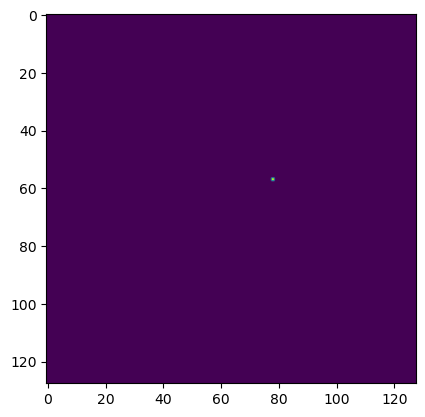

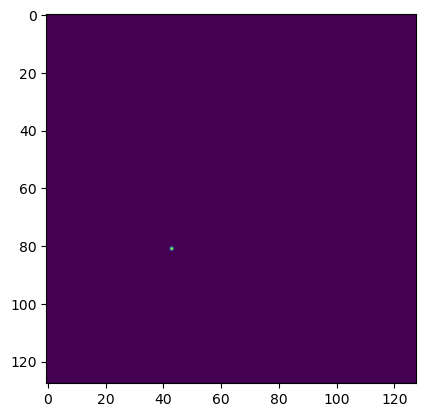

In [266]:
ignore_boundary = False
f, b = generate_problem()

plt.imshow(f)
plt.show()
plt.imshow(b)
plt.show()

In [241]:
train(epochs=100)

Epoch: 0, Loss: 0.016873802989721298, lr: = 0.00202
Epoch: 1, Loss: 0.017841938883066177, lr: = 0.0019998
Epoch: 2, Loss: 0.012401778250932693, lr: = 0.0020197979999999997
Epoch: 3, Loss: 0.014585649594664574, lr: = 0.0019996000199999997
Epoch: 4, Loss: 0.012949017807841301, lr: = 0.0020195960202
Epoch: 5, Loss: 0.014434664510190487, lr: = 0.0019994000599979998
Epoch: 6, Loss: 0.011412812396883965, lr: = 0.0020193940605979796
Epoch: 7, Loss: 0.015374155715107918, lr: = 0.001999200119992
Epoch: 8, Loss: 0.049807753413915634, lr: = 0.00197920811879208
Epoch: 9, Loss: 0.02410012111067772, lr: = 0.001999000199980001
Epoch: 10, Loss: 0.014829268679022789, lr: = 0.002018990201979801
Epoch: 11, Loss: 0.01456831581890583, lr: = 0.002039180103999599
Epoch: 12, Loss: 0.012286153621971607, lr: = 0.002059571905039595
Epoch: 13, Loss: 0.014741664752364159, lr: = 0.002038976185989199
Epoch: 14, Loss: 0.013711191713809967, lr: = 0.002059365947849091
Epoch: 15, Loss: 0.02150929719209671, lr: = 0.00203

In [284]:
ignore_boundary = False
train(epochs=100, fix_fi=True, iterations=300)

Epoch: 0, Loss: 0.28382842962940535, lr: = 0.00202
Epoch: 1, Loss: 0.04029281681093077, lr: = 0.0020402000000000003
Epoch: 2, Loss: 0.014149141754023731, lr: = 0.0020606020000000004
Epoch: 3, Loss: 0.006917866601919134, lr: = 0.0020812080200000005
Epoch: 4, Loss: 0.015186215285987903, lr: = 0.0020603959398000004
Epoch: 5, Loss: 0.0035621902261239787, lr: = 0.0020809998991980004
Epoch: 6, Loss: 0.0018431308537644024, lr: = 0.0021018098981899803
Epoch: 7, Loss: 0.0017058381531387568, lr: = 0.00212282799717188
Epoch: 8, Loss: 0.0017218630642552549, lr: = 0.0021015997172001612
Epoch: 9, Loss: 0.0011480054164227718, lr: = 0.002122615714372163
Epoch: 10, Loss: 0.0010830621347607424, lr: = 0.0021438418715158847
Epoch: 11, Loss: 0.001089454109314829, lr: = 0.002122403452800726
Epoch: 12, Loss: 0.005042923762036177, lr: = 0.0021011794182727184
Epoch: 13, Loss: 0.0008875188039382919, lr: = 0.0021221912124554454
Epoch: 14, Loss: 0.0007627713932500532, lr: = 0.00214341312458
Epoch: 15, Loss: 0.000

KeyboardInterrupt: 

In [287]:
ignore_boundary = False
train(epochs=100, fix_fi=False, iterations=300, lr = 0.0008)

Epoch: 0, Loss: 0.002100389536159734, lr: = 0.000808
Epoch: 1, Loss: 0.0016104091292557616, lr: = 0.0008160800000000001
Epoch: 2, Loss: 0.0018218031977691377, lr: = 0.0008079192
Epoch: 3, Loss: 0.0013463616992036502, lr: = 0.000815998392
Epoch: 4, Loss: 0.0009498424484627321, lr: = 0.0008241583759200001
Epoch: 5, Loss: 0.002062852303497493, lr: = 0.0008159167921608
Epoch: 6, Loss: 0.0021706913572658473, lr: = 0.000807757624239192
Epoch: 7, Loss: 0.0008092229431107019, lr: = 0.0008158352004815839
Epoch: 8, Loss: 0.0008933792847286289, lr: = 0.000807676848476768
Epoch: 9, Loss: 0.0008563233005891864, lr: = 0.0008157536169615357
Epoch: 10, Loss: 0.0009808919712668285, lr: = 0.0008075960807919203
Epoch: 11, Loss: 0.0015262957860250027, lr: = 0.0007995201199840011
Epoch: 12, Loss: 0.0010178955840334917, lr: = 0.0008075153211838411
Epoch: 13, Loss: 0.000926324714285632, lr: = 0.0008155904743956795
Epoch: 14, Loss: 0.0019154398880588512, lr: = 0.0008074345696517227
Epoch: 15, Loss: 0.00085010

KeyboardInterrupt: 

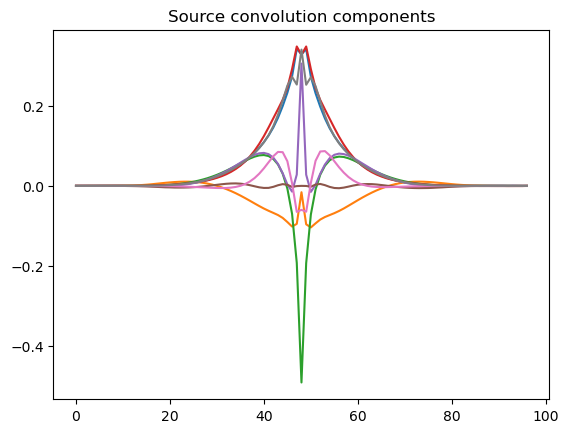

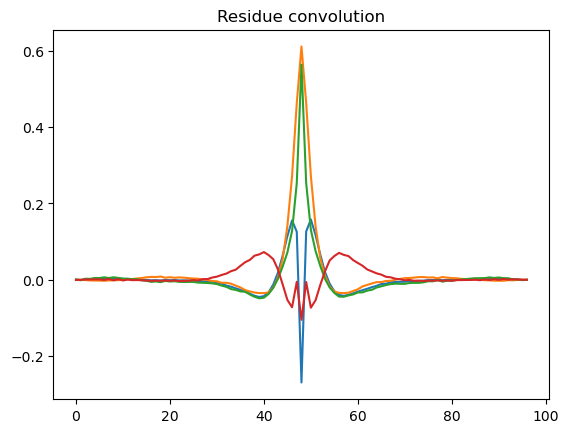

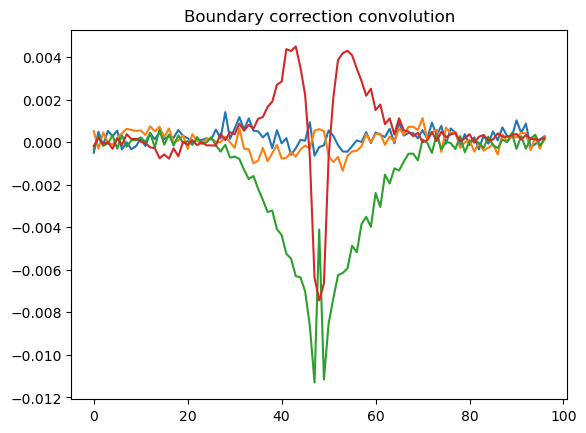

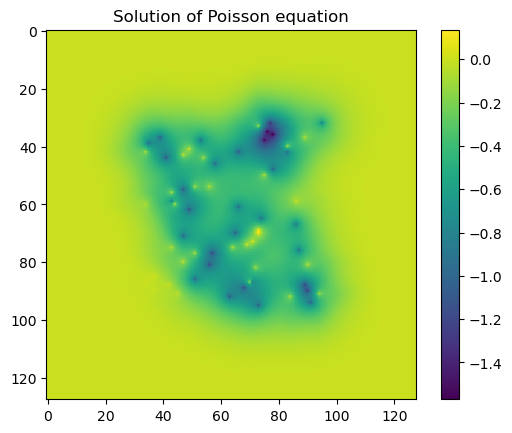

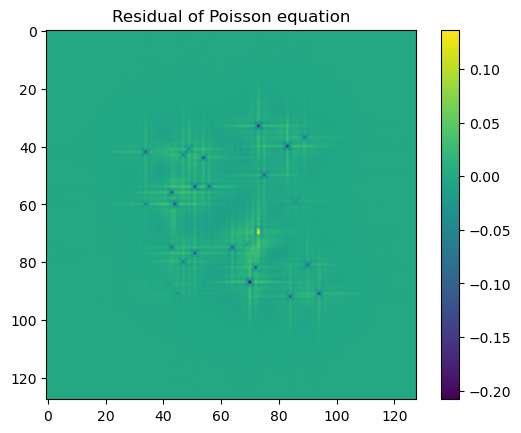

In [289]:
x = torch.arange(nf)
plt.plot(x, fi.T.detach().numpy())
plt.title('Source convolution components')
plt.show()

plt.plot(x, bi[:nr//2, :].T.detach().numpy())
plt.title('Residue convolution')
plt.show()

plt.plot(x, bi[nr//2:, :].T.detach().numpy())
plt.title('Boundary correction convolution')
plt.show()

f = torch.zeros(ny, nx)
f[ny//2, nx//2] = 1

point_n = 32
problem = generate_problem()
u = solution_estimate(fi, bi, problem)
# Verify the solution satisfies the Poisson equation
residual = poisson_eqn(u, problem)

# plot the solution
import matplotlib.pyplot as plt
plt.imshow(u.detach().numpy())
plt.colorbar()
#set title
plt.title('Solution of Poisson equation')
plt.show()

# plot the residual
# reshape the residual to 2D
residual = residual.reshape(ny, nx)
plt.imshow(residual.detach().numpy())
plt.colorbar()
#set title
plt.title('Residual of Poisson equation')
plt.show()



In [25]:
#write the separable solution ux to a glsl file
def write_as_glsl(vs, filename):
    #get the torch tensor
    vs = vs.detach().numpy()
    #get the shape
    N, nr = vs.shape

    nr2 = nr//2
    Nc = N//2
    #write the file
    with open(filename, "w") as f:
        f.write("//The filter: \n")
        f.write("const vec2 K[{}] = vec2 [](".format(N * nr2))
        array = ""
        for i in range(nr2):
            for j in range(N):
                array += "vec2({:.6e}, {:.6e}) ".format(vs[j, 2*i], vs[j, 2*i+1])
                if(i != nr2-1 or j != N-1):
                    array += ", "
        f.write(array)
        f.write(");\n")
        f.write("//center of the convolution \n")
        f.write("const int Nc = {}; \n".format(Nc))
        f.write("//number of ranks \n")
        f.write("const int Nr = {}; \n".format(nr2))
        f.write("//convolution size \n")
        f.write("const int N = {}; \n".format(N))
        

In [291]:
write_as_glsl(fi.T, "fi.glsl")